In [13]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings

In [14]:
data = pd.read_csv('D:\\financial_time_series\\bitcoin_price_history.csv', parse_dates=['startTime'])

data['startTime'] = pd.to_datetime(data['startTime'])
data.set_index('startTime', inplace=True)

data.sort_index(inplace=True)

def create_features(df):
    df['lag1'] = df['closePrice'].shift(1)
    df['lag2'] = df['closePrice'].shift(2)
    df['lag3'] = df['closePrice'].shift(3)
    df['rolling_mean'] = df['closePrice'].rolling(window=5).mean()
    df['rolling_std'] = df['closePrice'].rolling(window=5).std()
    df['volume_rolling_mean'] = df['volume'].rolling(window=5).mean()
    df['turnover_rolling_mean'] = df['turnover'].rolling(window=5).mean()

    df = df.dropna()

    return df

data = create_features(data)

In [15]:
X = data[['lag1', 'lag2', 'lag3', 'rolling_mean', 'rolling_std', 'volume_rolling_mean', 'turnover_rolling_mean']]
y = data['closePrice']

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [16]:
model = SVR(kernel='rbf', C=100, epsilon=0.1)

In [17]:
model.fit(X_train, y_train.ravel())

SVR(C=100)

In [18]:
y_pred = model.predict(X_test)

In [19]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Squared Error: 0.0030
Root Mean Squared Error: 0.0544


In [20]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_pred_unscaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

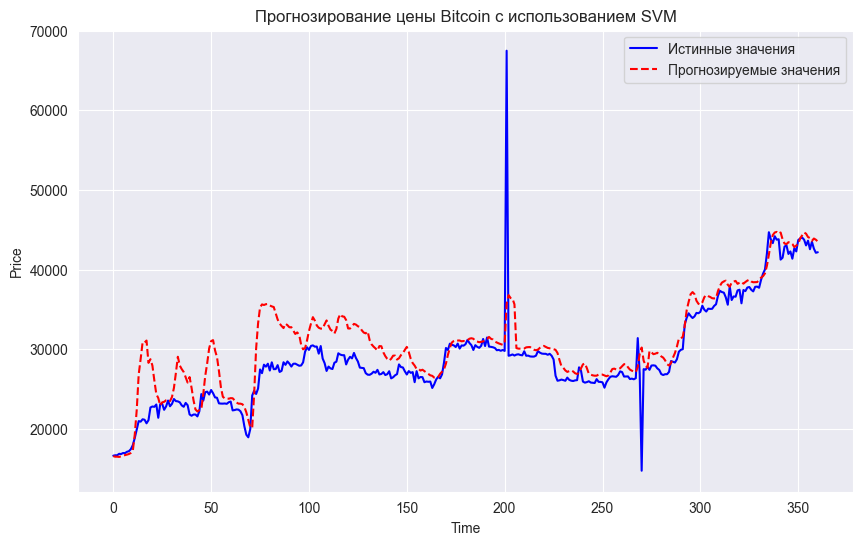

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, color='blue', label='Истинные значения')
plt.plot(y_pred_unscaled, color='red', label='Прогнозируемые значения', linestyle='--')
plt.title('Прогнозирование цены Bitcoin с использованием SVM')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [22]:
# 14. Построение кривых обучения
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model,
    X=X_scaled,
    y=y_scaled.ravel(),
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,  # 5-кратная кросс-валидация
    scoring='neg_mean_squared_error',
    shuffle=True,
    random_state=42
)

In [23]:
# Преобразование отрицательных значений MSE в положительные
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

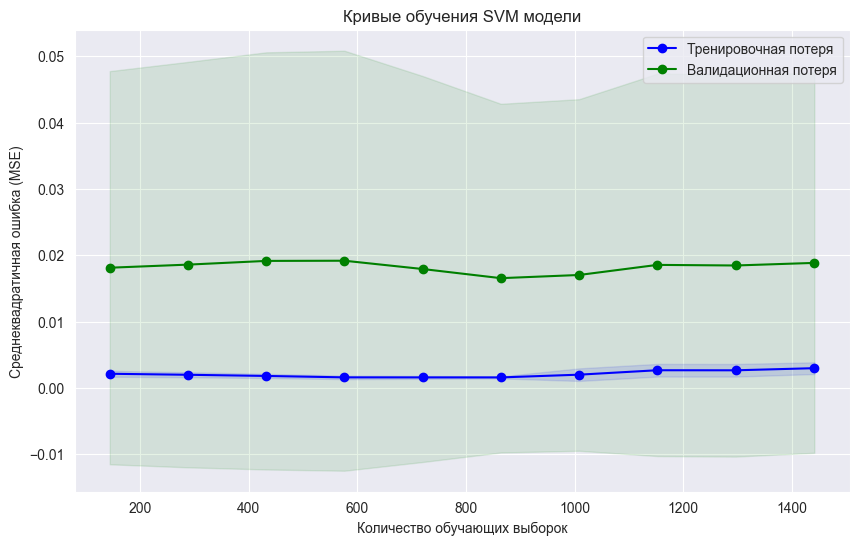

In [24]:
# Построение графика кривых обучения
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Тренировочная потеря')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='green', label='Валидационная потеря')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color='blue')
plt.fill_between(train_sizes,
                 validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std,
                 alpha=0.1, color='green')
plt.title('Кривые обучения SVM модели')
plt.xlabel('Количество обучающих выборок')
plt.ylabel('Среднеквадратичная ошибка (MSE)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()